In [2]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [3]:
import tensorflow as tf
import malaya_speech
import malaya_speech.train
from malaya_speech.train.model import revsic_glowtts as glowtts
import numpy as np

In [4]:
_pad = 'pad'
_start = 'start'
_eos = 'eos'
_punctuation = "!'(),.:;? "
_special = '-'
_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

MALAYA_SPEECH_SYMBOLS = (
    [_pad, _start, _eos] + list(_special) + list(_punctuation) + list(_letters)
)

In [5]:
input_ids = tf.placeholder(tf.int32, [None, None], name = 'input_ids')
lens = tf.placeholder(tf.int32, [None], name = 'lens')
mel_outputs = tf.placeholder(tf.float32, [None, None, 80])
mel_lengths = tf.placeholder(tf.int32, [None])
temperature = tf.placeholder(tf.float32, shape=(), name = 'temperature')
length_scale = tf.placeholder(tf.float32, shape=(), name = 'length_ratio')

In [6]:
config = glowtts.Config(mel = 80, vocabs = len(MALAYA_SPEECH_SYMBOLS))
config.temperature = temperature
config.length_scale = length_scale

In [7]:
model = glowtts.Model(config)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
instance = malaya_speech.train.model.revsic_glowtts.flow.actnorm.ActNorm

for k in range(len(model.decoder.flows)):
    if isinstance(model.decoder.flows[k], instance):
        model.decoder.flows[k].init = 1

In [9]:
loss, losses, attn = model.compute_loss(text = input_ids, 
                                        textlen = lens, 
                                        mel = mel_outputs, mellen = mel_lengths)
loss, losses, attn

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(<tf.Tensor 'add_4:0' shape=() dtype=float32>,
 {'nll': <tf.Tensor 'Mean:0' shape=() dtype=float32>,
  'durloss': <tf.Tensor 'Mean_1:0' shape=() dtype=float32>,
  'mel_': <tf.Tensor 'Reshape_2:0' shape=(?, ?, ?) dtype=float32>},
 <tf.Tensor 'StopGradient:0' shape=(?, ?, ?) dtype=float32>)

In [10]:
mel, mellen, attn_out = model(inputs = input_ids, lengths = lens)
mel, mellen, attn_out

(<tf.Tensor 'model/Reshape_50:0' shape=(?, ?, ?) dtype=float32>,
 <tf.Tensor 'model/mul_90:0' shape=(?,) dtype=int32>,
 <tf.Tensor 'model/transpose:0' shape=(?, ?, ?) dtype=float32>)

In [11]:
mel = tf.identity(mel, name = 'mel_output')
attn_out = tf.identity(attn_out, name = 'alignment_histories')

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [13]:
path = 'glowtts-yasmin'
ckpt_path = tf.train.latest_checkpoint(path)
ckpt_path

'glowtts-yasmin/model.ckpt-80000'

In [14]:
saver = tf.train.Saver()
saver.restore(sess, ckpt_path)

INFO:tensorflow:Restoring parameters from glowtts-yasmin/model.ckpt-80000


In [15]:
import re
from unidecode import unidecode
import malaya

pad_to = 8

def tts_encode(string: str, add_eos: bool = True):
    r = [MALAYA_SPEECH_SYMBOLS.index(c) for c in string if c in MALAYA_SPEECH_SYMBOLS]
    if add_eos:
        r = r + [MALAYA_SPEECH_SYMBOLS.index('eos')]
    return r

def put_spacing_num(string):
    string = re.sub('[A-Za-z]+', lambda ele: ' ' + ele[0] + ' ', string)
    return re.sub(r'[ ]+', ' ', string).strip()

def convert_to_ascii(string):
    return unidecode(string)

def collapse_whitespace(string):
    return re.sub(_whitespace_re, ' ', string)

def cleaning(string, add_eos = False):
    sequence = []
    string = convert_to_ascii(string)
    string = re.sub(r'[ ]+', ' ', string).strip()
    if string[-1] in ['-', ',']:
        string = string[:-1]
    if string[-1] != '.':
        string = string + '.'
    string = put_spacing_num(string)
    string = re.sub(r'[ ]+', ' ', string).strip()
    ids = tts_encode(string, add_eos = add_eos)
    text_input = np.array(ids)
    num_pad = pad_to - ((len(text_input) + 2) % pad_to)
    text_input = np.pad(
        text_input, ((1, 1)), 'constant', constant_values = ((1, 2))
    )
    text_input = np.pad(
        text_input, ((0, num_pad)), 'constant', constant_values = 0
    )
    
    return string, text_input

In [16]:
import matplotlib.pyplot as plt

In [17]:
t, ids = cleaning('Secara amnya, ini adalah koalisi yang melibatkan Pakatan Harapan, Keadilan, DAP dan Amanah kembali bersama Tun Dr Mahathir Mohamad dan kemnya')
t, ids

('Secara amnya , ini adalah koalisi yang melibatkan Pakatan Harapan , Keadilan , DAP dan Amanah kembali bersama Tun Dr Mahathir Mohamad dan kemnya .',
 array([ 1, 32, 44, 42, 40, 57, 40, 13, 40, 52, 53, 64, 40, 13,  8, 13, 48,
        53, 48, 13, 40, 43, 40, 51, 40, 47, 13, 50, 54, 40, 51, 48, 58, 48,
        13, 64, 40, 53, 46, 13, 52, 44, 51, 48, 41, 40, 59, 50, 40, 53, 13,
        29, 40, 50, 40, 59, 40, 53, 13, 21, 40, 57, 40, 55, 40, 53, 13,  8,
        13, 24, 44, 40, 43, 48, 51, 40, 53, 13,  8, 13, 17, 14, 29, 13, 43,
        40, 53, 13, 14, 52, 40, 53, 40, 47, 13, 50, 44, 52, 41, 40, 51, 48,
        13, 41, 44, 57, 58, 40, 52, 40, 13, 33, 60, 53, 13, 17, 57, 13, 26,
        40, 47, 40, 59, 47, 48, 57, 13, 26, 54, 47, 40, 52, 40, 43, 13, 43,
        40, 53, 13, 50, 44, 52, 53, 64, 40, 13,  9,  2,  0,  0,  0,  0]))

In [18]:
%%time

o = sess.run([mel, mellen, attn_out], feed_dict = {input_ids: [ids],
                                               lens: [len(ids)],
                                                  temperature: 0.6666, length_scale: 1.0})

CPU times: user 8.6 s, sys: 383 ms, total: 8.99 s
Wall time: 7.47 s


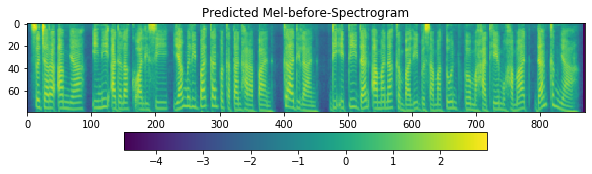

In [19]:
mel_outputs_ = np.reshape(o[0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

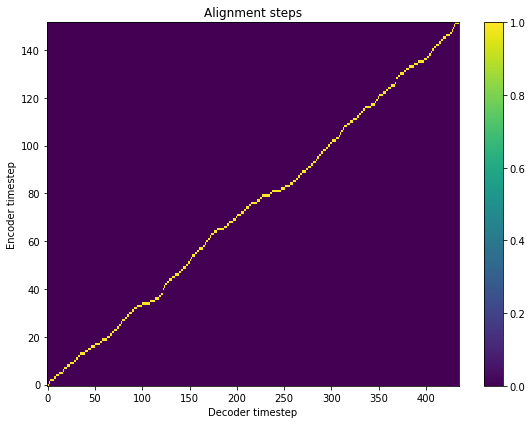

In [20]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o[-1][0].T,
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [21]:
import pickle

with open('a.pkl', 'wb') as fopen:
    pickle.dump([np.reshape(o[0], [-1, 80])], fopen)

In [22]:
saver = tf.train.Saver()
saver.save(sess, 'glowtts-yasmin-output/model.ckpt')

'glowtts-yasmin-output/model.ckpt'

In [23]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'gather' in n.op.lower()
        or 'input_ids' in n.name
        or 'lens' in n.name
        or 'temperature' in n.name
        or 'length_ratio' in n.name
        or 'mel_output' in n.name
        or 'alignment_histories' in n.name)
        and 'adam' not in n.name
        and 'global_step' not in n.name
        and 'Assign' not in n.name
        and 'AssignVariableOp' not in n.name
        and 'ReadVariableOp' not in n.name
        and 'Gather' not in n.name
        and 'IsVariableInitialized' not in n.name
    ]
)
strings.split(',')

['input_ids',
 'lens',
 'temperature',
 'length_ratio',
 'Variable',
 'Variable_1',
 'Variable_2',
 'Variable_3',
 'Variable_4',
 'Variable_5',
 'Variable_6',
 'Variable_7',
 'Variable_8',
 'Variable_9',
 'Variable_10',
 'Variable_11',
 'Variable_12',
 'Variable_13',
 'Variable_14',
 'Variable_15',
 'Variable_16',
 'Variable_17',
 'Variable_18',
 'Variable_19',
 'Variable_20',
 'Variable_21',
 'Variable_22',
 'Variable_23',
 'Variable_24',
 'Variable_25',
 'Variable_26',
 'Variable_27',
 'Variable_28',
 'Variable_29',
 'Variable_30',
 'Variable_31',
 'Variable_32',
 'Variable_33',
 'Variable_34',
 'Variable_35',
 'embedding/embedding_lookup',
 'model/embedding/embedding_lookup',
 'mel_output',
 'alignment_histories']

In [24]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [25]:
freeze_graph('glowtts-yasmin-output', strings)

INFO:tensorflow:Restoring parameters from glowtts-yasmin-output/model.ckpt
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 927 variables.
INFO:tensorflow:Converted 927 variables to const ops.
16949 ops in the final graph.


In [26]:
import struct

unknown = b'\xff\xff\xff\xff'

def load_graph(frozen_graph_filename, return_def = False):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        
    for node in graph_def.node:
        if node.op == 'RefSwitch':
            node.op = 'Switch'
            for index in range(len(node.input)):
                if 'moving_' in node.input[index]:
                    node.input[index] = node.input[index] + '/read'
        elif node.op == 'AssignSub':
            node.op = 'Sub'
            if 'use_locking' in node.attr:
                del node.attr['use_locking']
        elif node.op == 'AssignAdd':
            node.op = 'Add'
            if 'use_locking' in node.attr:
                del node.attr['use_locking']
        elif node.op in ['Assign', 'AssignVariableOp']:
            if node.op == 'AssignVariableOp':
                node.attr.setdefault('T')
                node.attr['T'].type = node.attr['dtype'].type
                del node.attr['dtype']
            node.op = 'Identity'
            if 'use_locking' in node.attr:
                del node.attr['use_locking']
            if 'validate_shape' in node.attr:
                del node.attr['validate_shape']
            if len(node.input) == 2:
                node.input[0] = node.input[1]
                del node.input[1]
        elif node.op == 'Switch' and 'wave_net_block' in node.name and 'AssignVariableOp_' in node.name:
            node.attr['T'].type = 1
    
    if return_def:
        return graph_def
    
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

In [27]:
g = load_graph('glowtts-yasmin-output/frozen_model.pb')

In [28]:
test_sess = tf.InteractiveSession(graph = g)

In [29]:
input_nodes = ['input_ids', 'lens', 'temperature', 'length_ratio']
inputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in input_nodes}

In [30]:
output_nodes = ['mel_output','alignment_histories']
outputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in output_nodes}

In [31]:
%%time

o = test_sess.run(outputs, feed_dict = {inputs['input_ids']: [ids], 
                                        inputs['lens']: [len(ids)],
                                        inputs['temperature']: 0.3333,
                                        inputs['length_ratio']: 1.0})

CPU times: user 3.42 s, sys: 166 ms, total: 3.59 s
Wall time: 2.31 s


In [32]:
o

{'mel_output': array([[[-3.2502382, -3.2125843, -3.0910065, ..., -1.7316797,
          -1.5224247, -1.6312689],
         [-2.9412472, -2.9202178, -2.9750023, ..., -1.6324115,
          -1.5836831, -1.6003318],
         [-2.7785451, -2.686595 , -2.8242111, ..., -1.5547086,
          -1.5545775, -1.5802873],
         ...,
         [-4.624472 , -4.624441 , -4.6124425, ..., -4.5925527,
          -4.6206555, -4.621344 ],
         [-4.581613 , -4.582585 , -4.6181083, ..., -4.596788 ,
          -4.610807 , -4.610841 ],
         [-4.582095 , -4.5837984, -4.6166754, ..., -4.5969086,
          -4.609362 , -4.610409 ]]], dtype=float32),
 'alignment_histories': array([[[1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 1.]]], dtype=float32)}

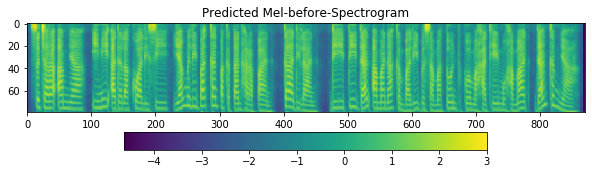

In [33]:
mel_outputs_ = np.reshape(o['mel_output'], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

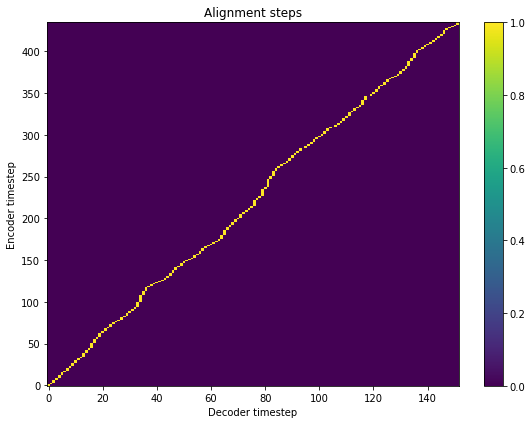

In [34]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o['alignment_histories'][0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [35]:
from tensorflow.tools.graph_transforms import TransformGraph

In [36]:
transforms = ['add_default_attributes',
             'remove_nodes(op=Identity, op=CheckNumerics)',
             'fold_batch_norms',
             'fold_old_batch_norms',
             'quantize_weights(fallback_min=-1024, fallback_max=1024)',
             'strip_unused_nodes',
             'sort_by_execution_order']

In [37]:
pb = 'glowtts-yasmin-output/frozen_model.pb'

In [38]:
input_graph_def = tf.GraphDef()
with tf.gfile.FastGFile(pb, 'rb') as f:
    input_graph_def.ParseFromString(f.read())

transformed_graph_def = TransformGraph(input_graph_def, 
                                           input_nodes,
                                           output_nodes, transforms)
    
with tf.gfile.GFile(f'{pb}.quantized', 'wb') as f:
    f.write(transformed_graph_def.SerializeToString())

Instructions for updating:
Use tf.gfile.GFile.


In [40]:
g = load_graph('glowtts-yasmin-output/frozen_model.pb.quantized')

In [41]:
test_sess = tf.InteractiveSession(graph = g)
inputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in input_nodes}
outputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in output_nodes}

In [42]:
%%time

o = test_sess.run(outputs, feed_dict = {inputs['input_ids']: [ids], 
                                        inputs['lens']: [len(ids)],
                                        inputs['temperature']: 0.3333,
                                        inputs['length_ratio']: 1.0})

CPU times: user 3.6 s, sys: 357 ms, total: 3.95 s
Wall time: 2.66 s


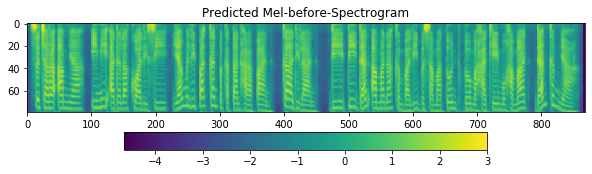

In [43]:
mel_outputs_ = np.reshape(o['mel_output'], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [44]:
b2_application_key_id = os.environ['b2_application_key_id']
b2_application_key = os.environ['b2_application_key']

In [45]:
from b2sdk.v1 import *
info = InMemoryAccountInfo()
b2_api = B2Api(info)
application_key_id = b2_application_key_id
application_key = b2_application_key
b2_api.authorize_account("production", application_key_id, application_key)
file_info = {'how': 'good-file'}
b2_bucket = b2_api.get_bucket_by_name('malaya-speech-model')

In [46]:
file = 'glowtts-yasmin-output/frozen_model.pb'
outPutname = 'text-to-speech-glowtts/yasmin/model.pb'
b2_bucket.upload_local_file(
    local_file=file,
    file_name=outPutname,
    file_infos=file_info,
)

In [47]:
file = 'glowtts-yasmin-output/frozen_model.pb.quantized'
outPutname = 'text-to-speech-glowtts/yasmin-quantized/model'
b2_bucket.upload_local_file(
    local_file=file,
    file_name=outPutname,
    file_infos=file_info,
)

In [48]:
!cp glowtts-yasmin-case/*.tfevents.* glowtts-yasmin-output
!cp -r glowtts-yasmin-case/eval glowtts-yasmin-output
!tar -cvf glowtts-yasmin-output.tar glowtts-yasmin-output

cp: cannot stat 'glowtts-yasmin-case/*.tfevents.*': No such file or directory
cp: cannot stat 'glowtts-yasmin-case/eval': No such file or directory
glowtts-yasmin-output/
glowtts-yasmin-output/model.ckpt.index
glowtts-yasmin-output/model.ckpt.data-00000-of-00001
glowtts-yasmin-output/frozen_model.pb.quantized
glowtts-yasmin-output/checkpoint
glowtts-yasmin-output/model.ckpt.meta
glowtts-yasmin-output/frozen_model.pb


In [ ]:
file = 'glowtts-yasmin-output.tar'
outPutname = 'pretrained/glowtts-yasmin-output.tar'
b2_bucket.upload_local_file(
    local_file=file,
    file_name=outPutname,
    file_infos=file_info,
)

In [ ]:
from malaya_boilerplate.huggingface import upload_dict

In [ ]:
files_mapping = {'glowtts-yasmin-output.tar': 'glowtts-yasmin-output.tar'}
upload_dict(model = 'pretrained-glowtts', files_mapping = files_mapping)

In [ ]:
files_mapping = {'glowtts-yasmin-output/frozen_model.pb': 'model.pb'}
upload_dict(model = 'text-to-speech-glowtts-yasmin', files_mapping = files_mapping)

In [ ]:
files_mapping = {'glowtts-yasmin-output/frozen_model.pb.quantized': 'model.pb'}
upload_dict(model = 'text-to-speech-glowtts-yasmin-quantized', files_mapping = files_mapping)